In [85]:
import numpy as np
import probnum as pn
import matplotlib.pyplot as plt

__True solution__: $$ w^\ast (t) = \sum_{j=1}^{M+1}  \frac{2 \sin(2 \pi j t )}{j^\beta} \quad \quad
 |\widehat{w}^\ast_l| \sim \frac{1}{l^{\beta}} $$ 


__Kernel__:

$$ k (t) = 1+ \sum_{j=-M}^{M+1}  \frac{\exp\{2 \pi i j t \}}{j^\gamma} \   \quad \quad
 \widehat{k}_l \sim \frac{1}{l^{\gamma}}$$



__Eigenvalues of covariance operator__: $$ \gamma_l =  \hat{k}_l\, \mathbb{E}[|\hat{X}_l|^2]) $$


__Source conditions__:

$$ 
\sum_{l \in \mathbb{Z}} \frac{{|\hat{w}^\ast_l|^2 } }{\hat{k}_l\, \gamma_l^{2\alpha}}  < + \infty
$$

In [86]:
def fourier_coeff(f_eval,  T):
    return np.fft.fft(f_eval, axis=0) * T / len(f_eval)

In [87]:
#CHOOSE number of input functions
N = 50

d = 2**15 # grid points


t_left = -.5
t_right = .5

T = t_right - t_left

t = np.linspace(t_left,t_right,d)

lamb =  1e-4 # regularization parameter

In [88]:
beta = .7
gamma =  .1
eta = .1

In [89]:
alpha_sup = (2*beta -1 - gamma) / 2*(gamma + eta)
print("alpha <" , alpha_sup)

alpha < 0.029999999999999995


In [90]:
alpha = .9 * alpha_sup

In [91]:
def sin_polin(t,alpha,M):
    return sum((2* np.sin(2*j*np.pi*t) / (j**alpha)) for j in range(1,M+2))

def fourier_expon(t,alpha,M):
    return sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(1,M+2)) + sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(-M,0))



#CHOOSE ground truth function and obs. noise         y_i = x_i * true_w + noise
sum_until = 30  # index M of truncation of the fourier series
true_w = sin_polin(t,beta,sum_until)                        

noise = 0.05

##fourier coefficients of w_true
true_w_fourier = fourier_coeff(true_w, T)  # normalized by the number of grid points

/tmp/ipykernel_94661/267831180.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


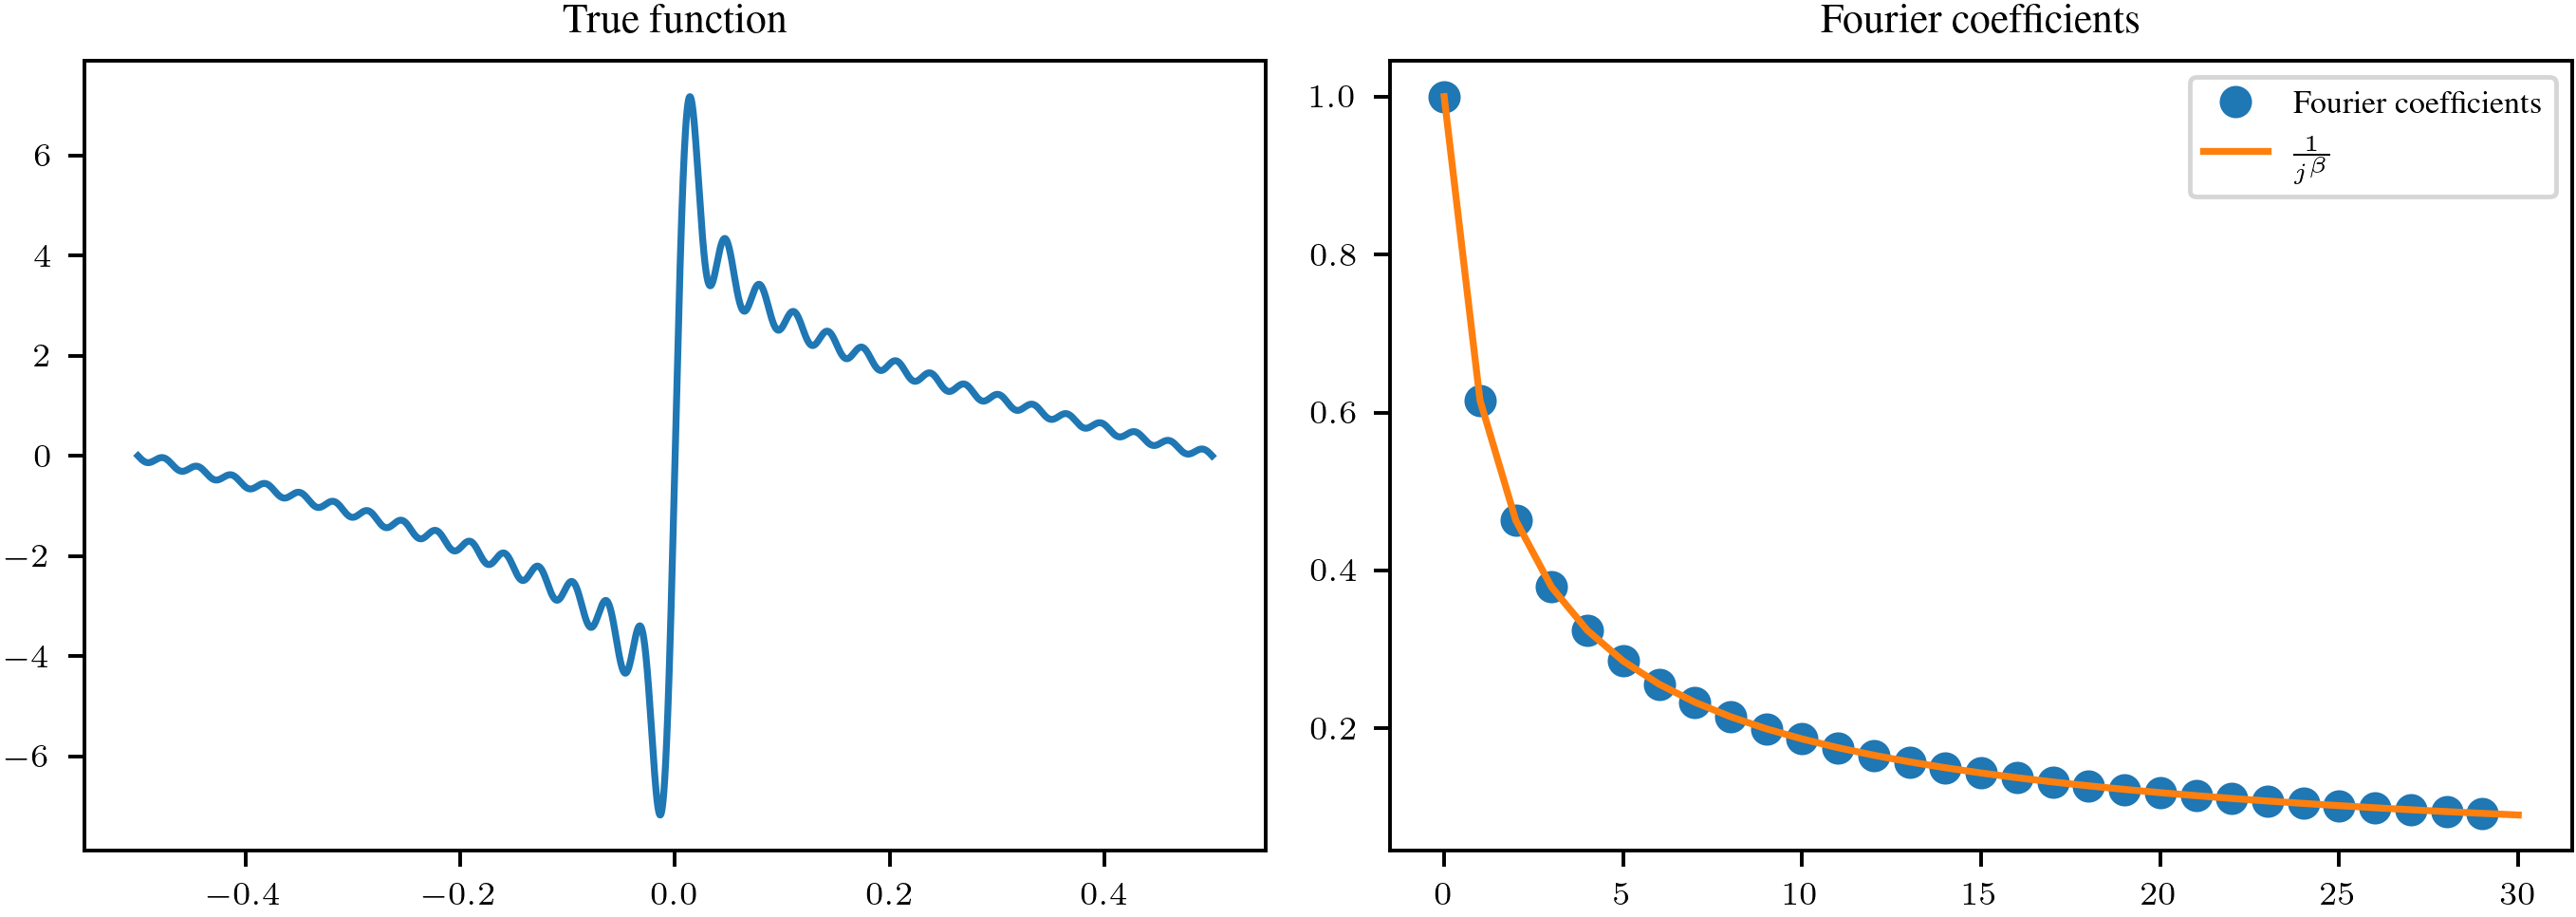

In [92]:

#plot the true function and its fourier coefficients in two subplots
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(8, 3))
ax1.plot(t,true_w)
ax1.set_title('True function')
ax2.plot(np.abs(true_w_fourier[1:sum_until+1]), 'o', label='Fourier coefficients')
aux_vec=np.arange(1,true_w_fourier.size+1, dtype=float)
ax2.plot(aux_vec[:sum_until+1]**(-beta), label=r'$\frac{1}{j^\beta}$')
ax2.set_title('Fourier coefficients')
ax2.legend()
plt.tight_layout()



In [93]:
# plt.plot(t,true_w)

1. __Frequency localized signals__: 
    $$X(t) = e^{2 \pi i L t} =  \cos(2 \pi L t) + i \sin(2 \pi L t) $$
    where $L$ is a $ \rho $-distributed random variable on $\mathbb{Z}$.
    
    Eigenvalues of covariance operator: $\gamma_l = \hat{k}_l \rho_l$ we choose $ \rho_l = \frac{1}{l^\eta} $


    Source conditions: 
    $$\sum_l \frac{l^{-2\beta}}{l^{-2\alpha(\gamma + \eta)} l^{-\gamma}} < \infty 
    \quad \rightarrow \quad \alpha < \frac{2 \beta -1 -\gamma}{2 (\gamma + \eta)}. $$




2. __Time localized signals__:  
    $$ X(t) = \frac{1}{2\delta}{1}_{[0,2 \delta]} (t-T) $$
    with $T$ random variable on $G$ and $\delta>0$.
    We choose $T \sim \mathcal{N}(\mu,\sigma^2)$.

    Eigenvalues of the covariance operator: $\gamma_j= \hat{k}_j  \text{sinc}^2({ 2 \pi \delta l } ) .$
    

In [94]:
#To draw samples from the distribution rho_l = l^-beta

def power_law_samples(N, L, eta):
    """
    Generates N samples drawn from a power law probability distribution on the integers
    with exponent eta.
    
    Args:
    - N: an integer specifying the number of samples to generate
    -L: the samples are drawn in the interval [1,L+1]
    - eta: a positive float specifying the exponent of the power law
    
    Returns:
    - A numpy array of N integers drawn from the power law distribution
    """
    # Define the power law probability density function
    def p(x):
        return 1.0 / (x**eta)
    
    # Define the normalization constant
    Z = sum([p(l) for l in range(1, L+1)])
    
    # Generate the samples
    samples = []
    while len(samples) < N:
        # Choose a random integer in the range [1, L+1] with probability proportional to p(l)
        n = np.random.choice(range(1, L+1), p=[p(l)/Z for l in range(1, L+1)])
        samples.append(n)
    
    return np.array(samples)

In [95]:
### Case 1. Inputs localized in frequency

##random vector for frequencies
# L_max = sum_until
# L = power_law_samples(N, L_max, eta)

# ##Inputs X = [x_1, .., x_N]
# X =  np.array([ np.cos(l*t*2*np.pi) + 1j*np.sin(l*t*2*np.pi)  for l in L]).T


## Case 2. Inputs localized in time

##Gaussian vector 
marvin = np.random.normal(.5,.2,N)

#Inputs X = [x_1, .., x_N]
delta = 0.076
X = np.array([np.where(((t-l) <= 2*delta) & ((t-l)>=0), 1, 0) for l in marvin]).T / (2*delta)

In [96]:
# fourier coefficients of X, Y and true sol  
X_fourier =  fourier_coeff(X,T)                                    #np.fft.fft(X, axis=0)  / d 

#take the conjugate of the fourier coefficients of X
X_fourier_conj = np.conj(X_fourier) 


In [97]:
#Output data matrix 
Y = np.zeros((d,N))   #noisy 
for i in range(0,N):
    Y[:,i] = np.fft.ifft(d*(true_w_fourier)*(X_fourier[:,i])) +  noise  * np.random.normal(0,1,d)
    #parte reale??

Y_fourier = fourier_coeff(Y,T)                                      #np.fft.fft(Y, axis=0) / d

/tmp/ipykernel_94661/3261165965.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[:,i] = np.fft.ifft(d*(true_w_fourier)*(X_fourier[:,i])) +  noise  * np.random.normal(0,1,d)


In [98]:
#kernel 

def Sobolev_fun(t):
    return 1 + (t**2)*np.pi**2 - np.pi**2*t + (np.pi**2)/6

#kernel function periodic on the torus

# def Sobolev_fun_periodic(t):
#     return np.where(t<=0, Sobolev_fun(t+1), Sobolev_fun(t))

# def periodic(t,sigma=1,ell=1):
#     return sigma**2 * np.exp( -2*(np.sin(np.pi*np.abs(t)))**2 / ell**2 )

# def Dirichlet(t,p):
#     return (2*p + 1)* ( np.sinc( (2*p + 1) * (t)  ) / np.sinc(t) )

# def kernel_fun(t,gamma,M):
#     return 1 + sum((np.exp(1j*2*k*np.pi*t) / (k**gamma)) for k in range(1,M+2)) #+ sum((np.exp(1j*2*k*np.pi*t) / (abs(k)**gamma)) for k in range(-M,0))


# M = sum_until

# kerfun_eval = kernel_fun(t,gamma, M)

# kernel_coeff = fourier_coeff(kerfun_eval, T)



In [99]:
kernel_coeff = np.zeros(t.size, dtype=complex)
kernel_coeff[0] = 1
for k in range(1,t.size):
    kernel_coeff[k] = k**(-gamma) 

/tmp/ipykernel_94661/651965399.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


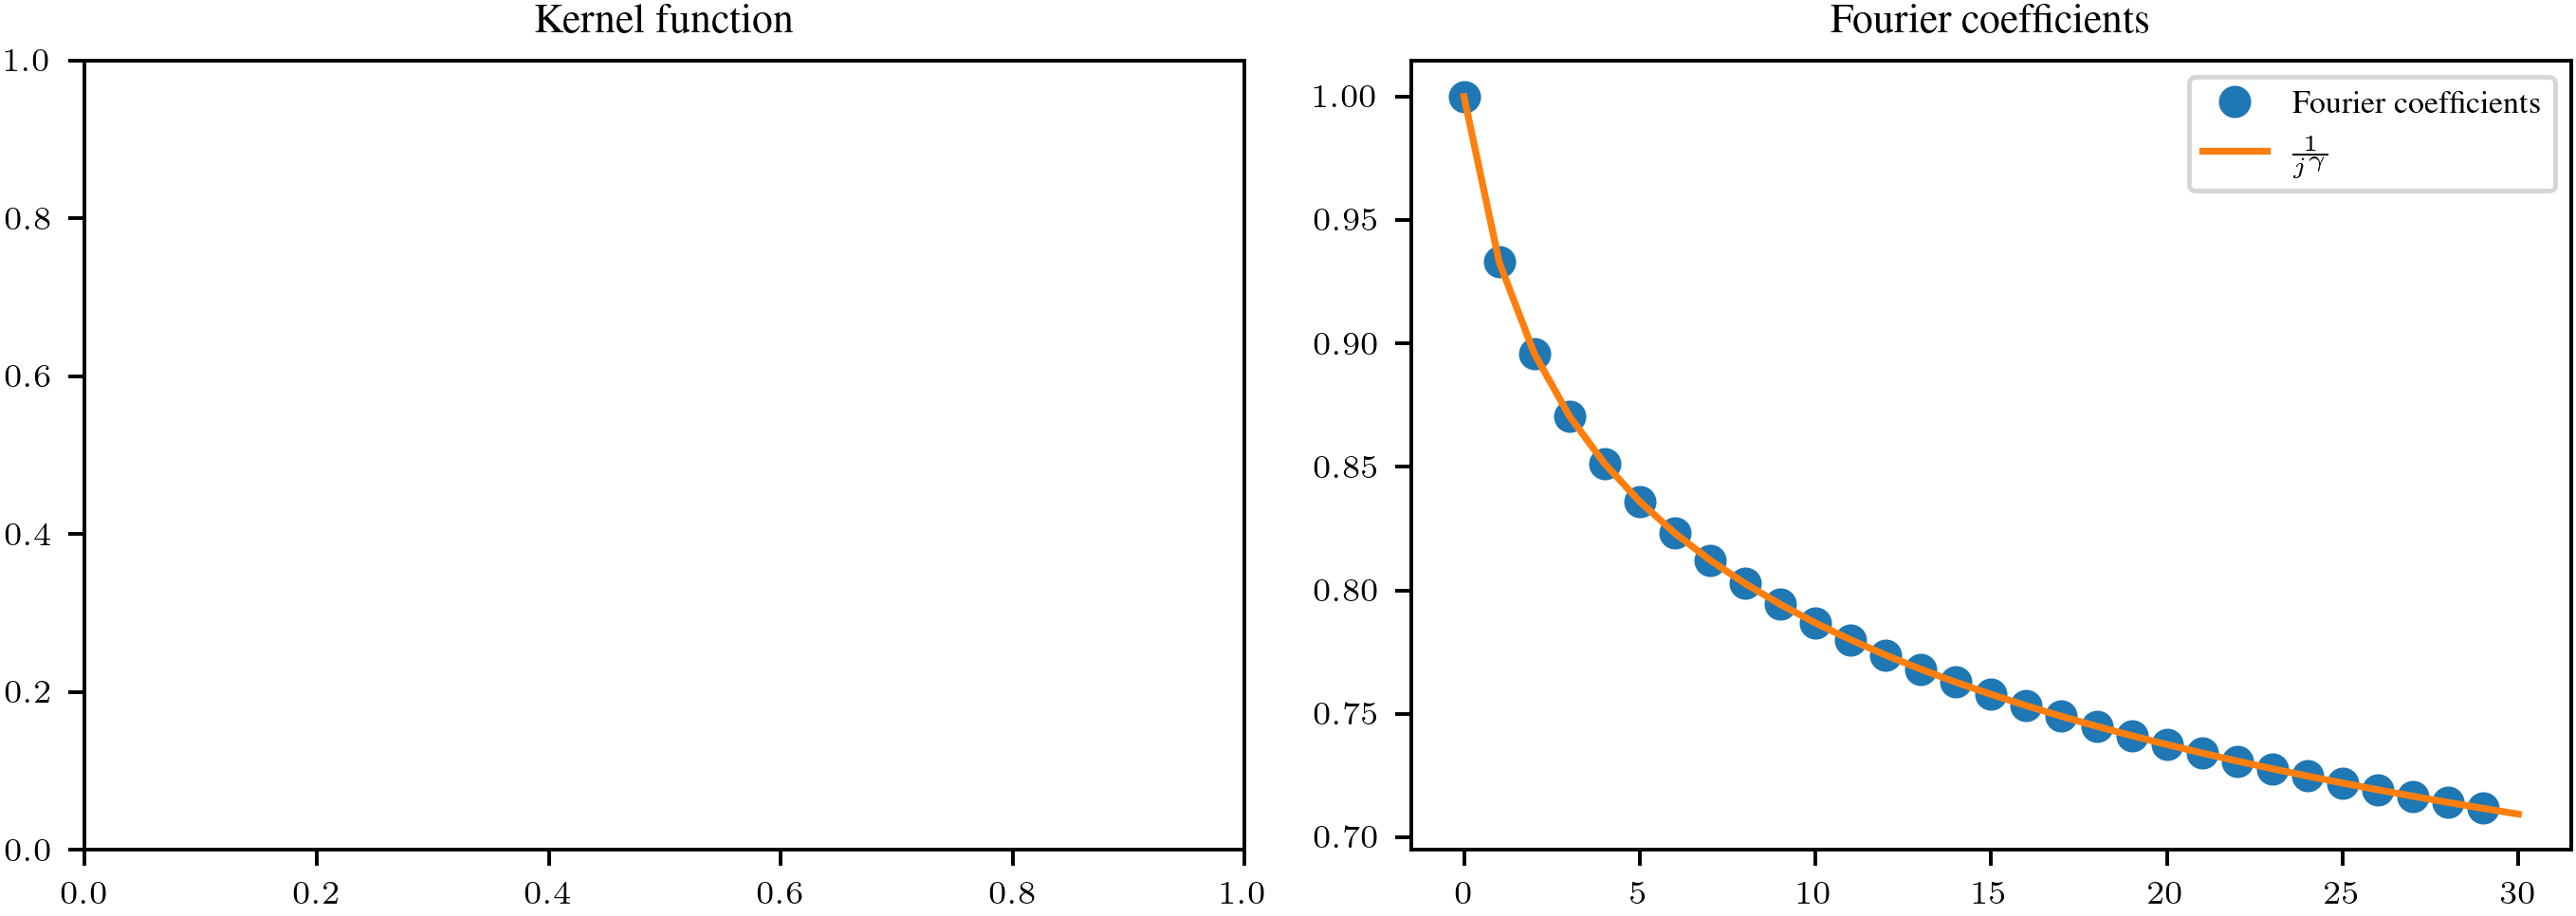

In [100]:

#plot the kernel function and its fourier coefficients in two subplots
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(8, 3))
# ax1.plot(t,kernel_fun(t,gamma,M))
ax1.set_title('Kernel function')
ax2.plot(kernel_coeff[1:M+1], 'o', label='Fourier coefficients')
aux_vec=np.arange(1,kernel_coeff.size+1, dtype=float)
ax2.plot(aux_vec[:M+1]**(-gamma), label=r'$\frac{1}{j^\gamma}$')
ax2.set_title('Fourier coefficients')
ax2.legend()
plt.tight_layout()



In [101]:
# freq = np.fft.fftfreq(t.size, d=1/t.size) 

In [102]:
# kernel_coeff   #SHOULD BE REAL AND POSITIVE!!!!


In [103]:
w_fourier = np.zeros(t.size, dtype=np.complex128)

# for l in range(t.size):
#     nominator = (X_fourier_conj[l,:] * Y_fourier[l,:]).sum() / N
#     denominator = (np.abs(X_fourier[l,:])**2).sum() / N + lamb * (1 / kernel_coeff[l])
#     w_fourier[l] = nominator / denominator

for l in range(t.size):
    eigenval = kernel_coeff[l] * (np.abs(X_fourier[l,:])**2).sum() / N
    term1 = kernel_coeff[l] / (eigenval + lamb)
    term2 = (X_fourier_conj[l,:] * Y_fourier[l,:]).sum() / N

    w_fourier[l] = term1 * term2



In [104]:
w = np.fft.ifft(w_fourier * d ) 

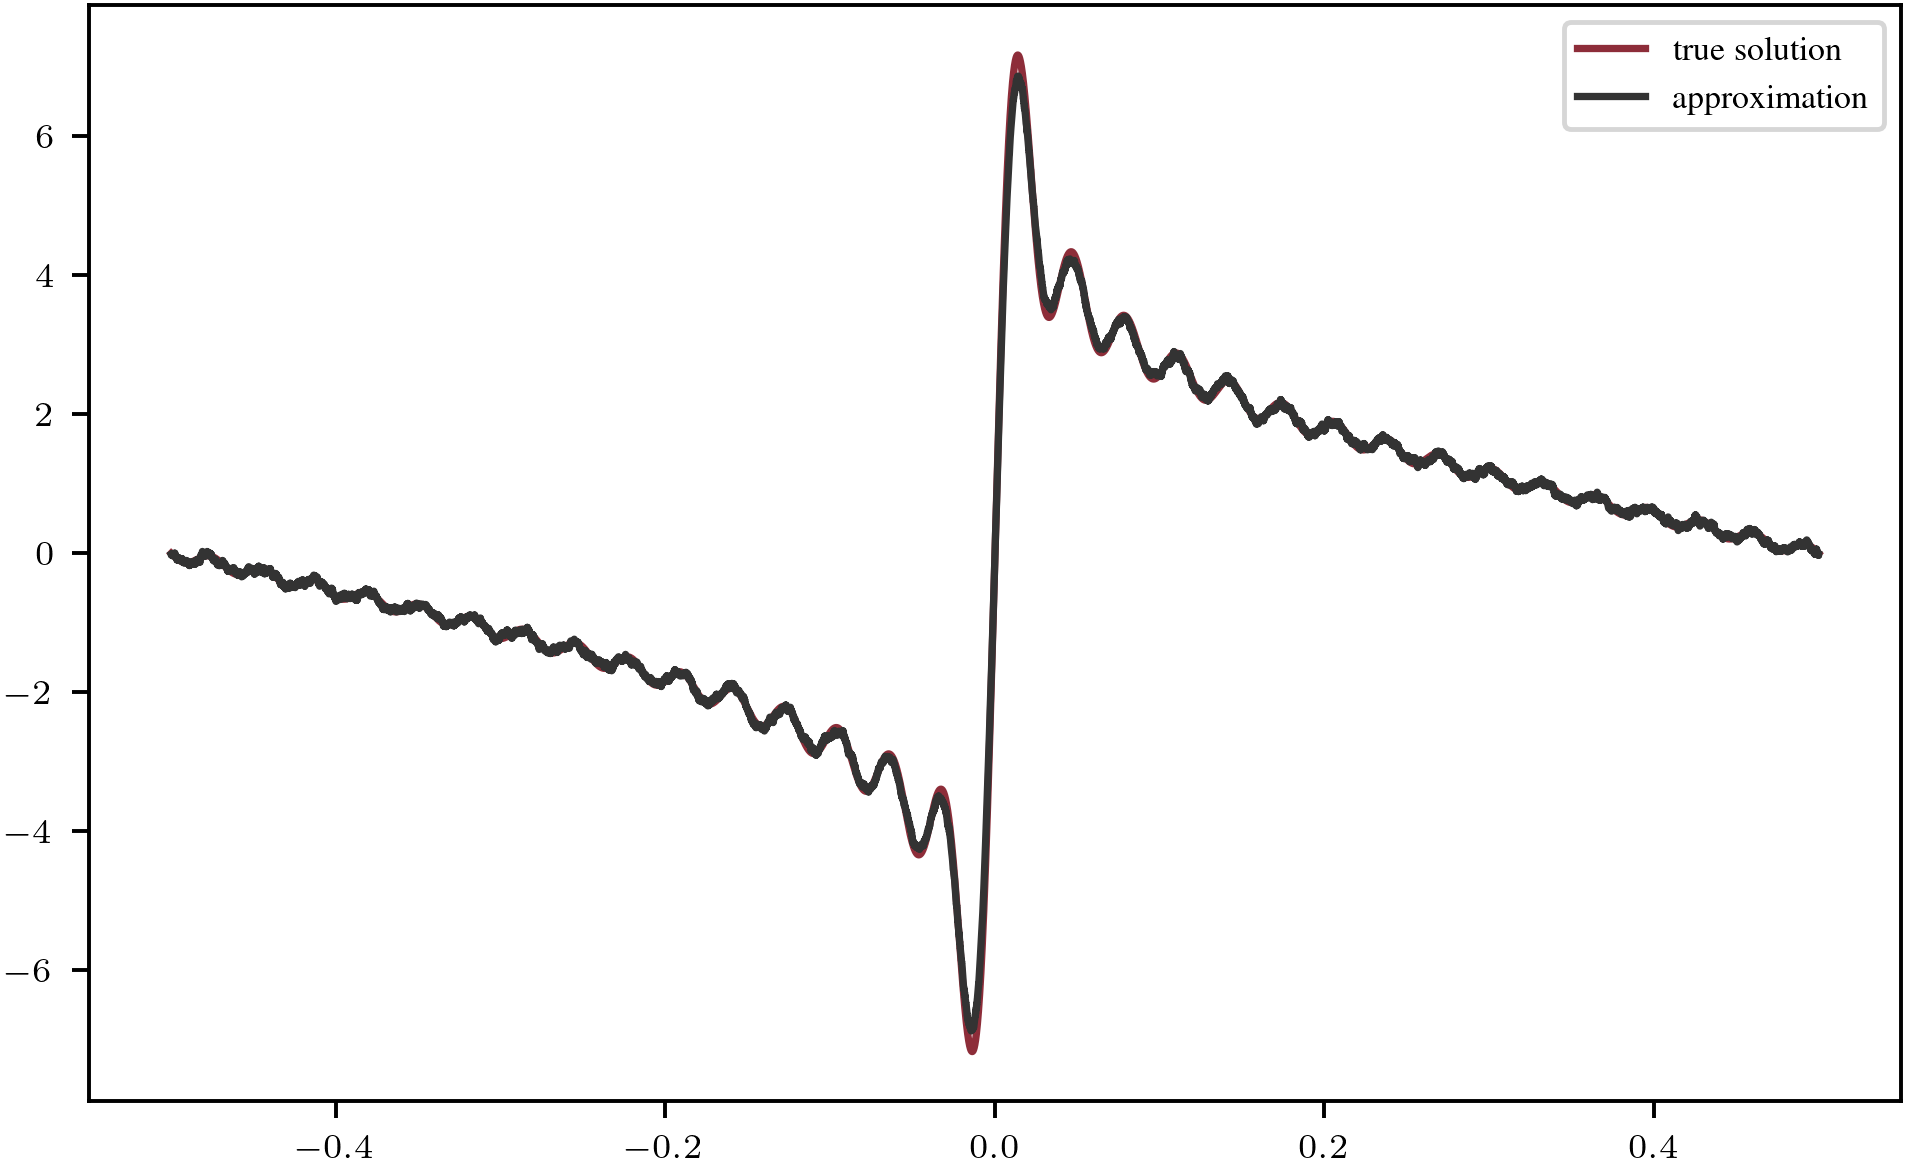

In [105]:
from tueplots import  bundles
plt.rcParams.update(bundles.neurips2023())
plt.rcParams.update({"figure.dpi": 350})


#define colors
red = np.array([141.0, 45.0, 57.0]) / 255.0
dark = np.array([51.0, 51.0, 51.0]) / 255.0

#plot true solution and w
fig, ax = plt.subplots(1, )
ax.plot(t, true_w, label='true solution', color = red)
ax.plot(t, w , label='approximation', color = dark)
ax.legend()


In [106]:
w_diff = w - true_w
w_diff_coeff = np.fft.fft(w_diff) / d
# w_diff_coeff = np.fft.fft(w)/d + np.fft.fft(true_w)/d
error_h_squared = (np.abs(w_diff_coeff)**2 / kernel_coeff).sum()

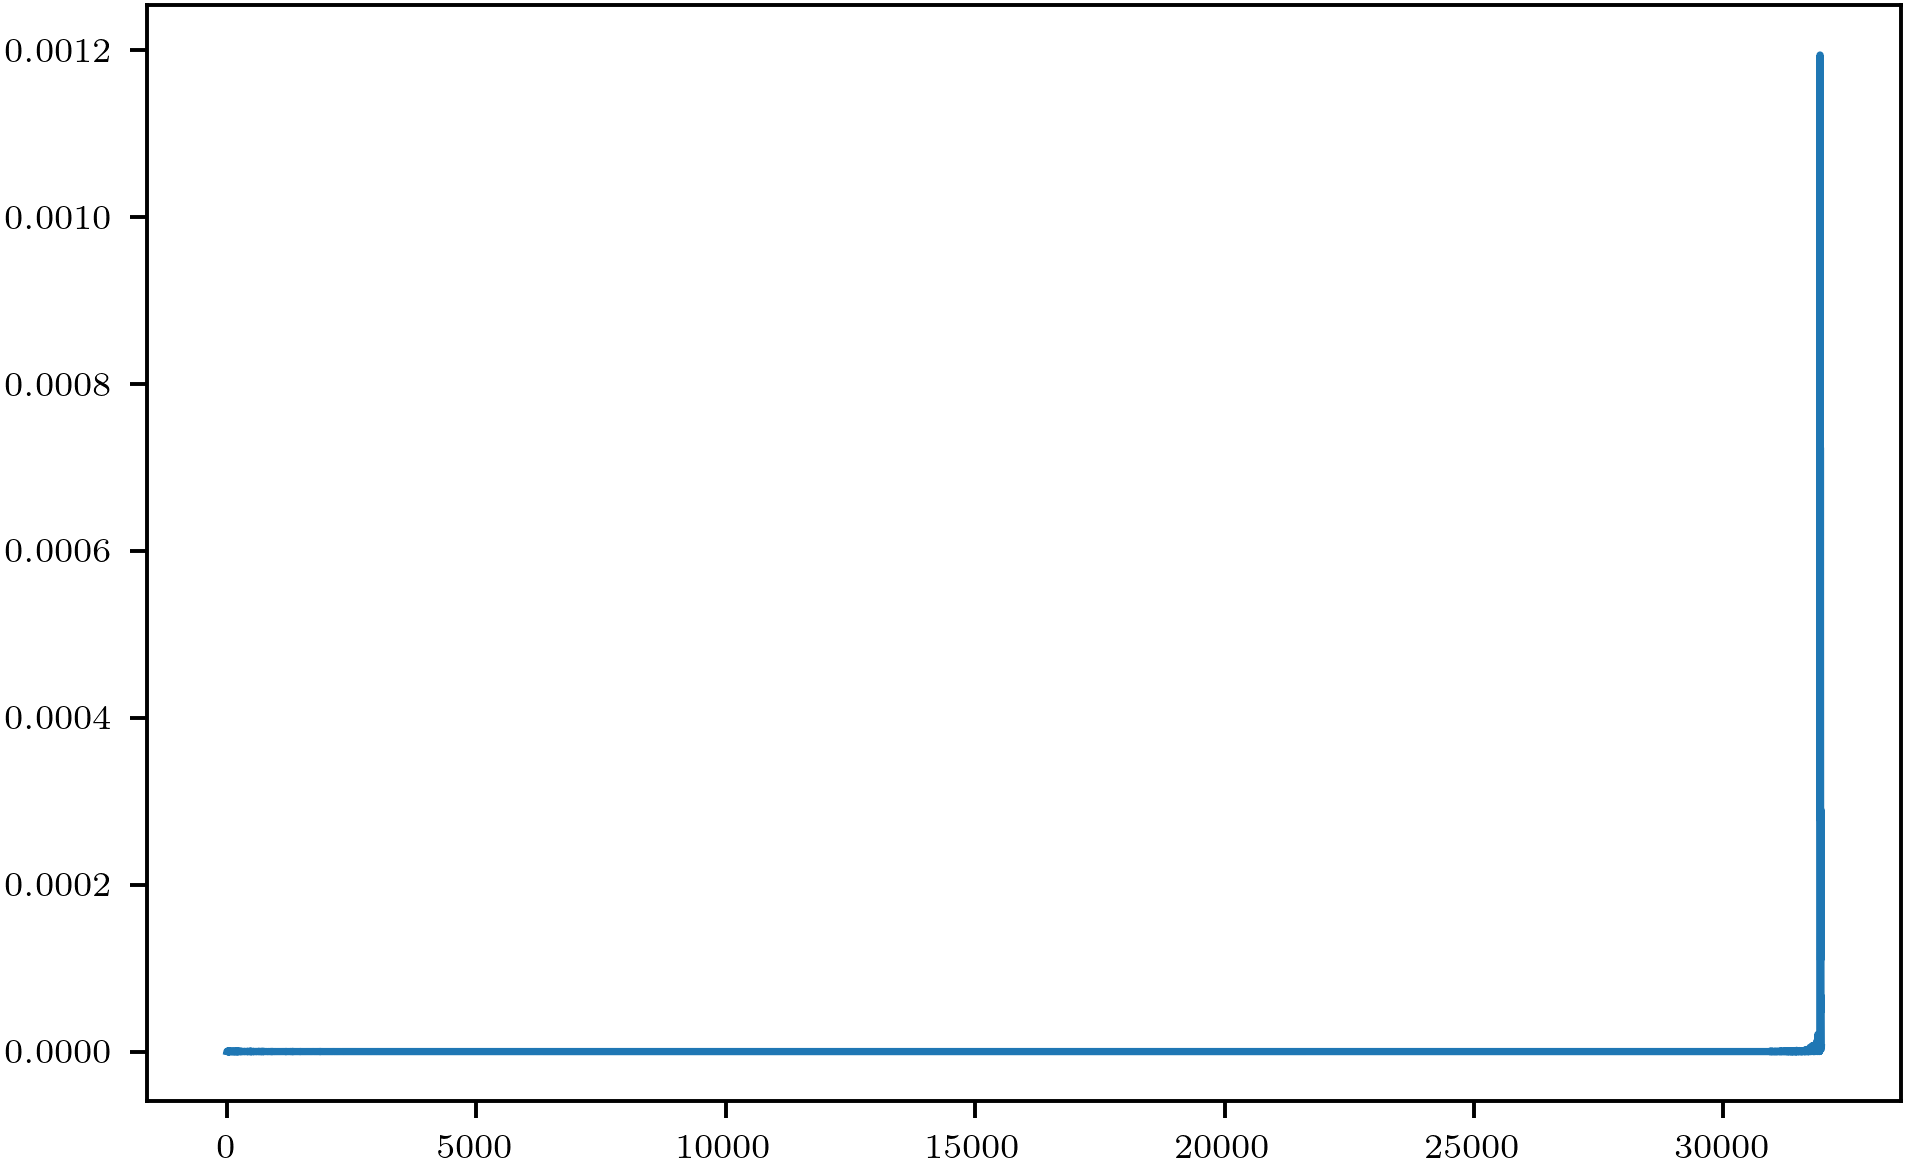

In [113]:
# until = 800

# vec = np.abs(w_diff_coeff[until:])**2 / (kernel_coeff[until:]).real
# plt.plot( vec)


In [109]:
error_h_squared

0.013090265287752924